✅ Data loaded & cleaned:
       seqn         berat        tinggi           bmi           age  fgb  \
0  130378.0  3.190000e+15  9.030000e+15 -8.730000e+14 -2.570000e+15  627   
1  130379.0  8.420000e+15  5.380000e+15  6.490000e+15  4.000000e+00   55   
2  130380.0 -2.950000e+16 -9.310000e+15  2.170000e+15 -2.290000e+16  866   
3  130386.0  4.490000e+16  4.760000e+16  2.710000e+14 -5.140000e+15  555   
4  130387.0  9.020000e+15 -7.240000e+15  1.660000e+16  4.570000e+16   59   

   hba1c  insulin  avg_systolyc  avg_dystolyc           hdl        status  \
0     56     9318  6.590000e+15  1.420000e+16 -4.090000e+15   Prediabetes   
1     56    11946 -9.090000e+15  1.940000e+15  4.770000e+14  Non-diabetes   
2     62     9798 -4.090000e+15  3.230000e+15 -1.590000e+16      Diabetes   
3     51     6828  2.270000e+16  9.680000e+14 -3.410000e+15  Non-diabetes   
4   1360      740  1.270000e+16  3.230000e+15 -5.680000e+14      Diabetes   

    insulin_log  
0  6.000000e+15  
1  1.120000e+16  
2

c:\Users\ASUS\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


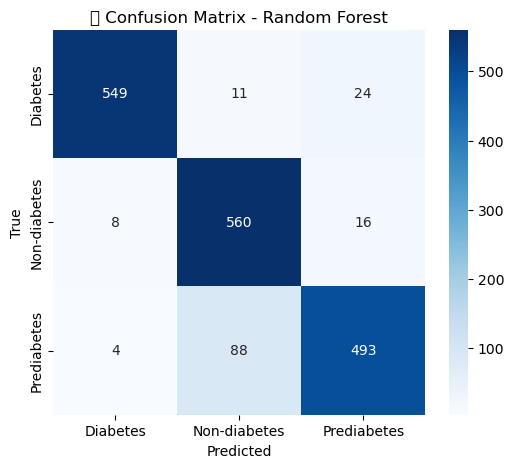

c:\Users\ASUS\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


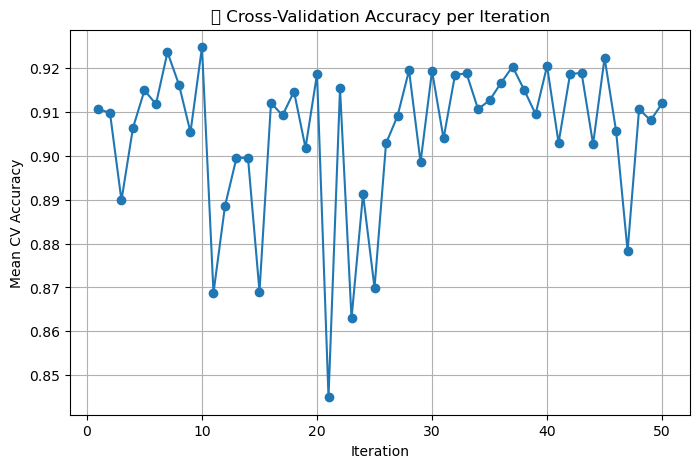

In [21]:
# ===============================================
# 🌲 RANDOM FOREST CLASSIFIER (Versi Dataset Fix)
# ===============================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from scipy.stats import randint
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------------
# 1️⃣ LOAD + CLEANING DATA
# ---------------------------
df = pd.read_csv("../Dataset/data_scaled_clean.csv", sep=';')  # <-- pakai semicolon

# --- 1.1 Cleaning: pastikan semua angka valid ---
df = df.replace(',', '.', regex=True)              # ganti koma ke titik untuk desimal
df.columns = df.columns.str.strip().str.lower()    # hilangkan spasi & lowercase kolom

for col in df.columns:
    if col != 'status':                            # konversi selain label ke numerik
        df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna()                                   # hilangkan NaN hasil konversi

print("✅ Data loaded & cleaned:")
print(df.head())

# ---------------------------
# 2️⃣ FITUR & LABEL
# ---------------------------
X = df.drop(columns=['status', 'hba1c', 'berat', 'tinggi', 'hdl'], errors='ignore')
y = df['status']

# Encode label
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("\nLabel mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# ---------------------------
# 3️⃣ SMOTE BALANCING
# ---------------------------
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

print("\nSetelah SMOTE:")
unique, counts = np.unique(y_resampled, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Class {u} ({le.inverse_transform([u])[0]}): {c}")

# ---------------------------
# 4️⃣ SPLIT DATA
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# ---------------------------
# 5️⃣ STANDARDISASI
# ---------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---------------------------
# 6️⃣ RANDOM FOREST + TUNING
# ---------------------------
rf = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("\n🚀 Training Random Forest ...")
random_search.fit(X_train_scaled, y_train)

print("\n=== Best Hyperparameters ===")
print(random_search.best_params_)

# ---------------------------
# 7️⃣ EVALUASI
# ---------------------------
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test_scaled)

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))

acc = accuracy_score(y_test, y_pred)
print(f"🎯 Final Test Accuracy: {acc:.4f}")

# ---------------------------
# 8️⃣ VISUALISASI
# ---------------------------
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('🧩 Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Cross-validation score plot
results = pd.DataFrame(random_search.cv_results_)
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(results['mean_test_score']) + 1),
         results['mean_test_score'], marker='o')
plt.title('📈 Cross-Validation Accuracy per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Mean CV Accuracy')
plt.grid(True)
plt.show()


<left>
    <h4>RANDOM FOREST HYPERTUNING BY RANDOMSEARCH </h4>
</left>

---

✅ Data loaded & cleaned:
       seqn         berat        tinggi           bmi           age  fgb  \
0  130378.0  3.190000e+15  9.030000e+15 -8.730000e+14 -2.570000e+15  627   
1  130379.0  8.420000e+15  5.380000e+15  6.490000e+15  4.000000e+00   55   
2  130380.0 -2.950000e+16 -9.310000e+15  2.170000e+15 -2.290000e+16  866   
3  130386.0  4.490000e+16  4.760000e+16  2.710000e+14 -5.140000e+15  555   
4  130387.0  9.020000e+15 -7.240000e+15  1.660000e+16  4.570000e+16   59   

   hba1c  insulin  avg_systolyc  avg_dystolyc           hdl        status  \
0     56     9318  6.590000e+15  1.420000e+16 -4.090000e+15   Prediabetes   
1     56    11946 -9.090000e+15  1.940000e+15  4.770000e+14  Non-diabetes   
2     62     9798 -4.090000e+15  3.230000e+15 -1.590000e+16      Diabetes   
3     51     6828  2.270000e+16  9.680000e+14 -3.410000e+15  Non-diabetes   
4   1360      740  1.270000e+16  3.230000e+15 -5.680000e+14      Diabetes   

    insulin_log  
0  6.000000e+15  
1  1.120000e+16  
2

c:\Users\ASUS\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


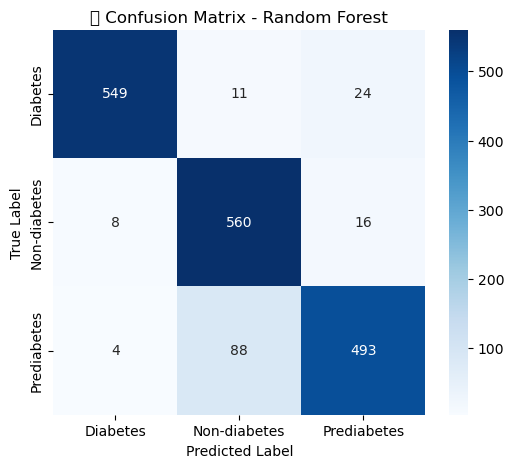

c:\Users\ASUS\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


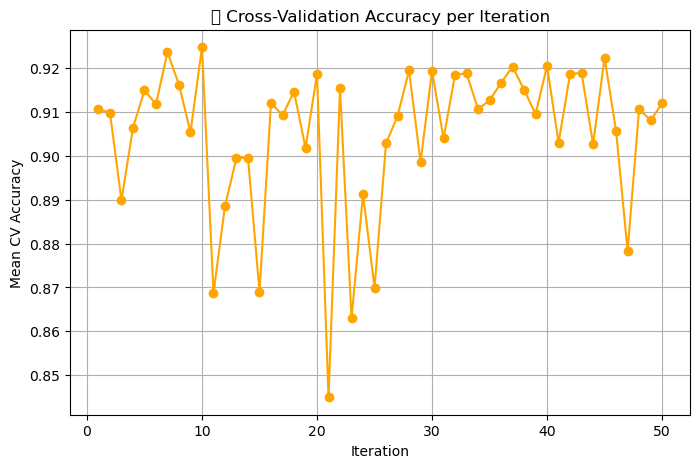

In [22]:
# ==============================================
# 🌲 RANDOM FOREST + RANDOMIZED SEARCH TUNING
# ==============================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from scipy.stats import randint

# ----------------------------------------------
# 1️⃣ LOAD DAN CLEANING DATA
# ----------------------------------------------
df = pd.read_csv("../Dataset/data_scaled_clean.csv", sep=';')  # <-- delimiter pakai ';'

# Ganti koma jadi titik dan rapikan kolom
df = df.replace(',', '.', regex=True)
df.columns = df.columns.str.strip().str.lower()

# Konversi kolom numerik
for col in df.columns:
    if col != 'status':
        df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna()
print("✅ Data loaded & cleaned:")
print(df.head())

# ----------------------------------------------
# 2️⃣ FITUR & LABEL
# ----------------------------------------------
# Drop fitur yang tidak dipakai
X = df.drop(columns=['status', 'hba1c', 'berat', 'tinggi', 'hdl'], errors='ignore')
y = df['status']

# Encode label kategori menjadi angka
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("\nLabel mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# ----------------------------------------------
# 3️⃣ ATASI IMBALANCE DENGAN SMOTE
# ----------------------------------------------
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

print("\nSetelah SMOTE:")
unique, counts = np.unique(y_resampled, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Class {u} ({le.inverse_transform([u])[0]}): {c}")

# ----------------------------------------------
# 4️⃣ SPLIT DATA
# ----------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# ----------------------------------------------
# 5️⃣ STANDARDISASI FITUR
# ----------------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ----------------------------------------------
# 6️⃣ RANDOM FOREST + RANDOMIZED SEARCH
# ----------------------------------------------
rf = RandomForestClassifier(random_state=42)

# Hyperparameter space
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# RandomizedSearchCV setup
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,              # jumlah kombinasi random yang dicoba
    cv=5,                   # 5-fold cross-validation
    scoring='accuracy',     # metrik utama
    n_jobs=-1,              # pakai semua core CPU
    random_state=42,
    verbose=1
)

print("\n🚀 Training Random Forest with RandomizedSearchCV ...")
random_search.fit(X_train_scaled, y_train)

print("\n=== 🏆 Best Hyperparameters ===")
print(random_search.best_params_)

# ----------------------------------------------
# 7️⃣ EVALUASI MODEL TERBAIK
# ----------------------------------------------
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test_scaled)

print("\n=== 📊 Classification Report ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))

acc = accuracy_score(y_test, y_pred)
print(f"\n🎯 Final Test Accuracy: {acc:.4f}")

# ----------------------------------------------
# 8️⃣ VISUALISASI HASIL MODEL
# ----------------------------------------------

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('🧩 Confusion Matrix - Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# --- CV Accuracy Plot ---
results = pd.DataFrame(random_search.cv_results_)
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(results['mean_test_score']) + 1),
         results['mean_test_score'], marker='o', color='orange')
plt.title('📈 Cross-Validation Accuracy per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Mean CV Accuracy')
plt.grid(True)
plt.show()
